In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting

In [2]:
stocks = pd.read_parquet('C:/tcc_dsa/data/processed/merged/merged_prices_10y.parquet')
indices = pd.read_parquet('C:/tcc_dsa/data/processed/merged/merged_indexes_10y.parquet')

In [3]:
indices.columns = indices.columns.str.replace('^', '', regex=False)

In [4]:
df_all = pd.merge(stocks, indices, left_index=True, right_index=True, how='left')

In [5]:
historico = stocks[['SUZB3', 'VALE3', 'ITUB4', 'PETR3', 'B3SA3', 'MGLU3', 'LREN3', 'RENT3', 'WEGE3', 'BRFS3']]["2014":"2023"]
final = stocks[['SUZB3', 'VALE3', 'ITUB4', 'PETR3', 'B3SA3', 'MGLU3', 'LREN3', 'RENT3', 'WEGE3', 'BRFS3']]["2024":]

In [ ]:
class backtest_markowitz:

    def __init__(self, prices, backtest, investimento, mu = None, S=None, weights=None, cum_return=None, init_portfolio=None, performance=None):
        self.prices = prices
        self.backtest = backtest
        self.investimento = investimento
        self.weights = weights
        self.cum_return = cum_return
        self.init_portfolio= init_portfolio
        self.mu = mean_historical_return(self.prices, frequency=252, compounding=True)
        self.S = sample_cov(self.prices, frequency=252)
        self.performance = performance
        
        
    def optimization_mv(self):
        portfolios= {"gmv":"Global Minimum Variance",
                    "msr": "Maximum Sharpe Ratio"}            
        gmv = []
        msr = []

        for ef_port in portfolios.keys():
            if ef_port == "gmv":
                ef = EfficientFrontier(self.mu, self.S, weight_bounds=(0, 1))
                portfolio = ef.min_volatility()
                gmv.append(portfolio)
            else:
                ef = EfficientFrontier(self.mu, self.S, weight_bounds=(0, 1))
                portfolio = ef.max_sharpe()
                msr.append(portfolio)

        mgv = pd.DataFrame(list(gmv[0].items()), columns=['Ticker', 'MGV'])
        msr = pd.DataFrame(list(msr[0].items()), columns=['Ticker', 'MSR'])

        # Merge the two DataFrames on the 'Ticker' column
        merged_df = pd.merge(mgv, msr, on='Ticker')
        merged_df["EW"] = 1/ merged_df.shape[0]
        merged_df.set_index('Ticker', inplace=True, drop=True)         
           
        self.weights = merged_df
    
    def backtest_performance(self):
        backtest = self.backtest
        for i in range(backtest.shape[1]):  # Itera pelas colunas usando índices
            backtest.iloc[:, i] = backtest.iloc[:, i] / backtest.iloc[0, i]
        
        start_investment_msr = []
        start_investment_mv = []
        start_investment_ew = []
        

        for portfolio in self.weights.columns:
            if portfolio == 'MGV':                
                posicao_inicial =  self.weights[portfolio] * self.investimento
                start_investment_mv.append(posicao_inicial)   
            elif portfolio == 'MSR':
                posicao_inicial =  self.weights[portfolio] * self.investimento
                start_investment_msr.append(posicao_inicial)
            else:
                posicao_inicial =  self.weights[portfolio] * self.investimento
                start_investment_msr.append(posicao_inicial) 
        
        start_investment_mv = pd.DataFrame(start_investment_mv)
        start_investment_msr = pd.DataFrame(start_investment_msr)
        start_investment_ew = pd.DataFrame(start_investment_ew)

        initial_position = pd.concat([start_investment_mv,start_investment_msr, start_investment_ew])
        
        evol_mgv = initial_position.loc["MGV",:] * backtest
        evol_msr = initial_position.loc["MSR",:] * backtest
        evol_ew = initial_position.loc["EW",:] * backtest

        evol_mgv['Total carteira'] = evol_mgv.sum(axis=1)
        evol_msr['Total carteira'] = evol_msr.sum(axis=1)
        evol_ew['Total carteira'] = evol_ew.sum(axis=1)

        self.cum_return = pd.DataFrame({"Carteira MSR": evol_msr['Total carteira'],"Carteira MGV": evol_mgv['Total carteira'],"Carteira EW": evol_ew['Total carteira']})

        self.performance = pd.DataFrame({"Retorno percentual (%)":round((self.cum_return.iloc[-1] - self.cum_return.iloc[0]) /  self.cum_return.iloc[-1],2) * 100,
                                         "Retorno Real R$": round(self.cum_return.iloc[-1] - self.cum_return.iloc[0],2)})
        
    
    def fronteira_eficiente_plot(self):
        ef = EfficientFrontier(self.mu, self.S, weight_bounds=(0, 1))
        fig, ax = plt.subplots(figsize=(10, 6))
        ef_max_sharpe = ef.deepcopy()
        plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True, show_tickers=True, )

        # Find the tangency portfolio
        ef_max_sharpe.max_sharpe()
        ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
        ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

        # Generate random portfolios
        n_samples = 30000
        w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
        rets = w.dot(ef.expected_returns)
        stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
        sharpes = rets / stds
        ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

        # Output
        ax.set_title(f"Fronteira Eficiênte com {n_samples} carteiras aleatórias")
        ax.set_xlabel("Volatilidade")
        ax.set_ylabel("Retornos")
        ax.legend()
        plt.tight_layout()
        plt.savefig("ef_scatter.png", dpi=200)
        plt.show(fig)
      

    def start_opt(self):
        self.optimization_mv(self)
        self.backtest_performance(self)
        self.fronteira_eficiente_plot(self)


In [199]:
x = backtest_markowitz(historico,final,5000).start_opt()


TypeError: backtest_markowitz.optimization_mv() takes 1 positional argument but 2 were given

In [188]:
x.backtest_performance()

<Axes: xlabel='date'>

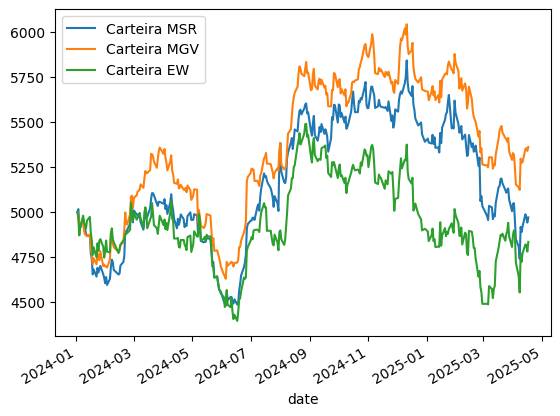

In [189]:
x.cum_return.plot()

In [190]:
x.performance

,Retorno percentual (%),Retorno Real R$
Carteira MSR,-1.0,-30.03
Carteira MGV,7.0,360.06
Carteira EW,-3.0,-166.00


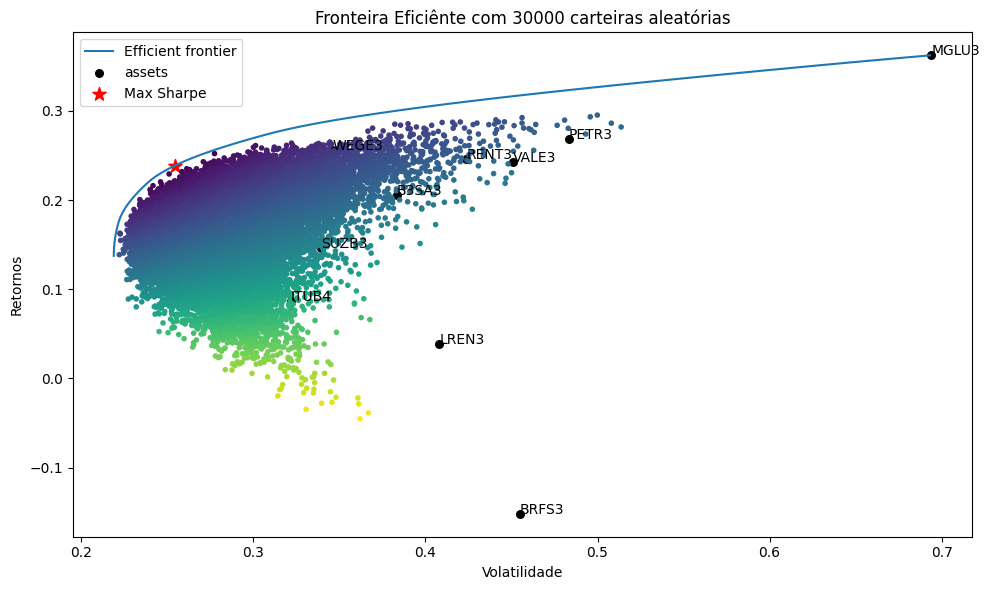

In [ ]:
x.fronteira_eficiente_plot()